In [3]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

from datasets import load_dataset
import pandas as pd

/Users/monika/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [146]:
file_path = 'Datasets/udataset.xlsx'
#file_path = "new.xlsx"

In [147]:
df = pd.read_excel(file_path)
df.head()

,Substance,Substance_lower,CAS_number,SMILES,Additional info,Irritation,Source
0,Heptanal,heptanal,111-71-7,CCCCCCC=O,-,I,Lukáš - 2006 Howard Maibach paper.pdf
1,Lilestralis/lilial,lilestralis/lilial,80-54-6,CC(CC1=CC=C(C=C1)C(C)(C)C)C=O,-,I,NaN
2,1-Bromopentane,1-bromopentane,110-53-2,CCCCCBr,-,I,NaN
3,dl-Citronellol,dl-citronellol,106-22-9,CC(CCC=C(C)C)CCO,-,I,NaN
4,d-Limonene,d-limonene,5989-27-5,CC1=CCC(CC1)C(=C)C,-,I,NaN


## Data loading

In [142]:
#https://huggingface.co/datasets/maomlab/AttentiveSkin
# Load dataset with a specified config
dataset_train = load_dataset("maomlab/AttentiveSkin", "Irrit_Neg", split="train")
dataset_test = load_dataset("maomlab/AttentiveSkin", "Irrit_Neg", split="test")
# Convert to Pandas DataFrame
df_train = pd.DataFrame(dataset_train)
df_test = pd.DataFrame(dataset_test)

df = pd.concat([df_train, df_test], ignore_index=True)
#df = df_test

# Display the first few rows
print(df.head())

                                                Name  \
0                    JP_CHRIP:\np-Nitrochlorobenzene   
1                          US_HSDB:\n4-Acetylanisole   
2                    NZ_CCID:\n4-Nitrobenzyl bromide   
3  EU_REACH:\nbutyl N-[(butylsulfanyl)methanethio...   
4  EU_REACH:\n(1S,3R,5R,6S,8R,10R,11S,13R,15R,16S...   

                                             Synonym        CAS RN  Y  \
0  JP_CHRIP:\np-Chloronitrobenzene\n1-Chloro-4-ni...      100-00-5  0   
1                                               None      100-06-1  1   
2                                               None      100-11-8  1   
3                                               None  1001320-38-2  0   
4                                               None    10016-20-3  0   

                                       Detailed Page  \
0  JP_CHRIP: https://www.nite.go.jp/chem/ghs/21-m...   
1  US_HSDB: https://pubchem.ncbi.nlm.nih.gov/sour...   
2  NZ_CCID: https://www.epa.govt.nz/database-sear...   


## Descriptor calculation

In [143]:
rabits = df[df["OECD TG 404"] == "Provided"]
#df = pd.concat([df_old, rabits], ignore_index=True)

In [110]:
def calculate_descriptors(df):
    # List to hold descriptor data for each row
    descriptor_data = []
    
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            # Append a dictionary of None values for all descriptors if SMILES is invalid
            descriptor_data.append({desc[0]: None for desc in Descriptors.descList})
            continue
        
        descriptors = {}
        for descriptor, function in Descriptors.descList:
            try:
                descriptors[descriptor] = function(mol)
            except Exception:
                descriptors[descriptor] = None
        
        descriptor_data.append(descriptors)
    
    # Create a DataFrame for descriptor values with the same index as the original DataFrame
    descriptors_df = pd.DataFrame(descriptor_data, index=df.index)
    
    # Concatenate original DataFrame with descriptor DataFrame
    df = pd.concat([df, descriptors_df], axis=1)
    
    return df

In [148]:
df = calculate_descriptors(df)

[11:23:28] WARNING: not removing hydrogen atom without neighbors
[11:23:28] WARNING: not removing hydrogen atom without neighbors
[11:23:28] WARNING: not removing hydrogen atom without neighbors


In [145]:
rabits = calculate_descriptors(rabits)
#f_o = calculate_descriptors(df_o)

In [86]:
rabits.shape

(1338, 224)

In [107]:
df_old.shape

(446, 217)

## Columns cleaning

In [149]:
columns_to_drop = ["Substance", "Substance_lower", "CAS_number", "SMILES", "Additional info", "Source"]

# Drop the columns using the drop() method with axis=1 (columns)
df = df.drop(columns_to_drop, axis=1)
df.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,I,9.768009,9.768009,0.750000,0.750000,0.395123,9.125000,114.188,100.076,114.104465,...,0,0,0,0,0,0,0,0,3,0
1,I,10.535393,10.535393,0.116191,0.116191,0.689906,13.600000,204.313,184.153,204.151415,...,0,0,0,0,0,0,0,0,0,0
2,I,3.350347,3.350347,1.167500,1.167500,0.429137,9.000000,151.047,139.959,150.004412,...,0,0,0,0,0,0,0,0,1,0
3,I,8.629773,8.629773,0.329353,0.329353,0.606746,12.727273,156.269,136.109,156.151415,...,0,0,0,0,0,0,0,0,0,0
4,I,3.974575,3.974575,0.767315,0.767315,0.485034,25.800000,136.238,120.110,136.125201,...,0,0,0,0,0,0,0,0,0,0


In [150]:
columns_to_drop = ["Name", "Synonym", "CAS RN", "Detailed Page", "Evidence", "OECD TG 404", "Data Source","Frequency","SMILES", "SMILES URL", "SMILES Source",   "Canonical SMILES", "Split"]

# Drop the columns using the drop() method with axis=1 (columns)
rabits = rabits.drop(columns_to_drop, axis=1)
rabits.head()

,Y,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,10.074698,10.074698,0.059630,-0.461975,0.463602,9.300000,157.556,153.524,156.993056,...,0,0,0,0,0,0,0,0,0,0
3,0,11.126813,11.126813,0.432918,-0.432918,0.578640,9.733333,249.401,230.249,249.085721,...,1,0,0,0,0,0,0,0,2,0
4,0,11.216799,11.216799,0.998871,-2.148030,0.117489,55.363636,972.846,912.366,972.316941,...,0,0,0,0,0,0,0,0,0,0
7,0,14.593817,14.593817,0.033954,-0.843042,0.446513,25.925926,376.531,342.259,376.257772,...,0,0,0,0,0,0,0,0,1,0
8,0,8.223565,8.223565,0.296296,0.296296,0.494725,8.500000,108.100,104.068,108.032363,...,0,0,0,0,0,0,0,0,0,0


In [151]:
rabits.rename(columns={"Y":"Irritation"}, inplace=True)

In [152]:
rabits.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,10.074698,10.074698,0.059630,-0.461975,0.463602,9.300000,157.556,153.524,156.993056,...,0,0,0,0,0,0,0,0,0,0
3,0,11.126813,11.126813,0.432918,-0.432918,0.578640,9.733333,249.401,230.249,249.085721,...,1,0,0,0,0,0,0,0,2,0
4,0,11.216799,11.216799,0.998871,-2.148030,0.117489,55.363636,972.846,912.366,972.316941,...,0,0,0,0,0,0,0,0,0,0
7,0,14.593817,14.593817,0.033954,-0.843042,0.446513,25.925926,376.531,342.259,376.257772,...,0,0,0,0,0,0,0,0,1,0
8,0,8.223565,8.223565,0.296296,0.296296,0.494725,8.500000,108.100,104.068,108.032363,...,0,0,0,0,0,0,0,0,0,0


In [153]:
df = pd.concat([df, rabits], ignore_index=True)

In [154]:
df.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,I,9.768009,9.768009,0.750000,0.750000,0.395123,9.125000,114.188,100.076,114.104465,...,0,0,0,0,0,0,0,0,3,0
1,I,10.535393,10.535393,0.116191,0.116191,0.689906,13.600000,204.313,184.153,204.151415,...,0,0,0,0,0,0,0,0,0,0
2,I,3.350347,3.350347,1.167500,1.167500,0.429137,9.000000,151.047,139.959,150.004412,...,0,0,0,0,0,0,0,0,1,0
3,I,8.629773,8.629773,0.329353,0.329353,0.606746,12.727273,156.269,136.109,156.151415,...,0,0,0,0,0,0,0,0,0,0
4,I,3.974575,3.974575,0.767315,0.767315,0.485034,25.800000,136.238,120.110,136.125201,...,0,0,0,0,0,0,0,0,0,0


In [155]:
columns_to_drop = ["BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW"]

# Drop the columns using the drop() method with axis=1 (columns)
df = df.drop(columns_to_drop, axis=1)

In [156]:
df['Irritation'] = df['Irritation'].replace({'I': 1, 'NI': 0})
df.head()

/var/folders/n4/lx5wz8kj2r79g9p8wxdnqk580000gn/T/ipykernel_87070/3730350621.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Irritation'] = df['Irritation'].replace({'I': 1, 'NI': 0})


,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,9.768009,9.768009,0.750000,0.750000,0.395123,9.125000,114.188,100.076,114.104465,...,0,0,0,0,0,0,0,0,3,0
1,1,10.535393,10.535393,0.116191,0.116191,0.689906,13.600000,204.313,184.153,204.151415,...,0,0,0,0,0,0,0,0,0,0
2,1,3.350347,3.350347,1.167500,1.167500,0.429137,9.000000,151.047,139.959,150.004412,...,0,0,0,0,0,0,0,0,1,0
3,1,8.629773,8.629773,0.329353,0.329353,0.606746,12.727273,156.269,136.109,156.151415,...,0,0,0,0,0,0,0,0,0,0
4,1,3.974575,3.974575,0.767315,0.767315,0.485034,25.800000,136.238,120.110,136.125201,...,0,0,0,0,0,0,0,0,0,0


In [157]:
df.shape

(1784, 203)

In [158]:
x = df.drop(columns="Irritation")
x[x.duplicated()]

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
118,9.930324,9.930324,0.180556,-0.706019,0.566819,13.428571,102.133,92.053,102.068080,42,...,0,0,0,0,0,0,0,0,0,0
128,8.555556,8.555556,0.000000,-2.861111,0.254382,12.400000,104.062,103.054,103.954409,26,...,0,0,0,0,0,0,0,0,0,0
129,3.389746,3.389746,1.161990,1.161990,0.513503,9.750000,243.970,231.874,241.930575,50,...,0,0,0,0,0,0,0,0,3,0
132,10.612396,10.612396,0.084676,-0.790414,0.781775,10.285714,186.210,176.130,186.068080,70,...,0,0,0,0,0,0,0,0,0,0
133,10.909695,10.909695,0.043526,-0.043526,0.429221,10.000000,186.295,164.119,186.161980,78,...,0,0,0,0,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,2.298611,2.298611,0.583333,0.583333,0.500244,12.000000,100.205,84.077,100.125201,44,...,0,0,0,0,0,0,0,0,0,0
1755,10.464402,10.464402,0.094028,-0.094028,0.427720,9.111111,130.187,116.075,130.099380,54,...,0,0,0,0,0,0,0,0,1,0
1757,3.550417,3.550417,1.059028,1.059028,0.361192,7.333333,82.146,72.066,82.078250,34,...,0,0,0,0,0,0,0,0,1,0
1760,2.221732,2.221732,1.306926,1.306926,0.435883,9.750000,150.312,136.200,150.053692,50,...,0,0,0,0,0,0,0,0,3,0


In [159]:
indexes_to_delete = x[x.duplicated()].index

In [162]:
df.drop(indexes_to_delete)

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,9.768009,9.768009,0.750000,0.750000,0.395123,9.125000,114.188,100.076,114.104465,...,0,0,0,0,0,0,0,0,3,0
1,1,10.535393,10.535393,0.116191,0.116191,0.689906,13.600000,204.313,184.153,204.151415,...,0,0,0,0,0,0,0,0,0,0
2,1,3.350347,3.350347,1.167500,1.167500,0.429137,9.000000,151.047,139.959,150.004412,...,0,0,0,0,0,0,0,0,1,0
3,1,8.629773,8.629773,0.329353,0.329353,0.606746,12.727273,156.269,136.109,156.151415,...,0,0,0,0,0,0,0,0,0,0
4,1,3.974575,3.974575,0.767315,0.767315,0.485034,25.800000,136.238,120.110,136.125201,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,0,11.926133,11.926133,0.000252,-0.123207,0.233308,13.142857,402.572,360.236,402.298139,...,0,0,0,0,0,0,0,0,7,0
1780,0,13.255046,13.255046,0.087407,-1.869290,0.675230,9.923077,204.393,197.337,204.016080,...,0,0,0,0,0,0,0,0,0,0
1781,0,12.331817,12.331817,0.025114,-3.579830,0.860025,11.000000,290.340,276.228,290.061280,...,0,0,1,0,0,0,0,0,0,0
1782,0,12.014002,12.014002,0.116908,-0.585188,0.684993,9.850000,272.260,260.164,272.079707,...,0,0,0,0,0,0,0,0,0,0


## Nan values

In [163]:
# Count NaN values per column
nan_counts = df.isna().sum()

# Filter columns with NaN values and sort by count
nan_columns_sorted = nan_counts[nan_counts > 0].sort_values(ascending=False)

print(nan_columns_sorted)

MaxPartialCharge       4
MinPartialCharge       4
MaxAbsPartialCharge    4
MinAbsPartialCharge    4
dtype: int64


In [164]:
# Count the number of rows before dropping NaN values
num_rows_before = df.shape[0]

# Drop rows with NaN values
df.dropna(inplace=True)

# Count the number of rows after dropping NaN values
num_rows_after = df.shape[0]

# Calculate the number of rows dropped
num_rows_dropped = num_rows_before - num_rows_after

print("Number of rows dropped:", num_rows_dropped)

Number of rows dropped: 4


In [165]:
df.shape

(1780, 203)

In [166]:
df = df.reset_index(drop=True)

# Basic statistics

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Columns: 203 entries, Irritation to fr_urea
dtypes: float64(98), int64(105)
memory usage: 2.8 MB


In [168]:
df.nunique()

Irritation              2
MaxAbsEStateIndex    1631
MaxEStateIndex       1631
MinAbsEStateIndex    1614
MinEStateIndex       1647
                     ... 
fr_thiazole             3
fr_thiocyan             2
fr_thiophene            3
fr_unbrch_alkane       28
fr_urea                 3
Length: 203, dtype: int64

In [169]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Irritation,1780.0,0.200562,0.400533,0.000000,0.000000,0.000000,0.000000,1.000000
MaxAbsEStateIndex,1780.0,10.077936,2.991026,0.000000,8.944342,10.839905,12.135009,15.633873
MaxEStateIndex,1780.0,10.077304,2.990944,0.000000,8.944342,10.838284,12.135009,15.633873
MinAbsEStateIndex,1780.0,0.330378,0.599546,0.000000,0.064285,0.181083,0.377317,8.226135
MinEStateIndex,1780.0,-0.998024,1.703408,-11.027778,-1.180614,-0.510397,-0.028912,6.000000
...,...,...,...,...,...,...,...,...
fr_thiazole,1780.0,0.006180,0.085260,0.000000,0.000000,0.000000,0.000000,2.000000
fr_thiocyan,1780.0,0.000562,0.023702,0.000000,0.000000,0.000000,0.000000,1.000000
fr_thiophene,1780.0,0.008989,0.100186,0.000000,0.000000,0.000000,0.000000,2.000000
fr_unbrch_alkane,1780.0,1.152809,3.506714,0.000000,0.000000,0.000000,0.000000,39.000000


## Drop constant columns

In [133]:
constant_columns = df.columns[df.nunique() <= 1]  # Columns with 1 or fewer unique values
print(f"Constant columns removed: {list(constant_columns)}")
df = df.drop(columns=constant_columns)

Constant columns removed: ['SMR_VSA8', 'SlogP_VSA9', 'fr_benzodiazepine', 'fr_dihydropyridine', 'fr_isothiocyan', 'fr_nitroso', 'fr_prisulfonamd']


## Skewness

In [170]:
skewness_values = df.skew()
skewness_df = skewness_values.reset_index()
skewness_df.columns = ['Feature', 'Skewness']
skewness_df.sort_values(by="Skewness", inplace=True)
print(skewness_df)

skewed_features = skewness_df[skewness_df['Skewness'].abs() > 2]
print(len(skewed_features))

               Feature   Skewness
93         VSA_EState5  -9.436516
4       MinEStateIndex  -1.673982
97         VSA_EState9  -1.429460
1    MaxAbsEStateIndex  -1.039597
2       MaxEStateIndex  -1.039066
..                 ...        ...
131           fr_HOCCN  33.521872
35                 Ipc  39.513739
151        fr_barbitur  42.190046
199        fr_thiocyan  42.190046
155           fr_diazo  42.190046

[203 rows x 2 columns]
141


In [171]:

for index, row in skewness_df.iterrows():
    feature = row['Feature']
    skewness = row['Skewness']
    
    # Check for NaN before applying transformation
    if df[feature].isna().all():
        print(f"Skipping {feature} because it contains only NaN values.")
        continue
    
    # Right-skewed: Skewness > 1
    if skewness > 1:
        print(f"Transforming {feature} (right-skewed)...")
        df[feature] = np.sqrt(np.abs(df[feature]))  # Handle negatives safely
    
    # Left-skewed: Skewness < -1
    elif skewness < -1:
        print(f"Transforming {feature} (left-skewed)...")
        if df[feature].nunique() > 1:  # Ensures variance
            scaler = PowerTransformer(method='yeo-johnson')
            df[feature] = pd.Series(scaler.fit_transform(df[[feature]]).flatten(), index=df.index)
        else:
            print(f"Skipping {feature} due to low variance.")
    
    # No significant skewness: Leave the feature as is
    else:
        print(f"{feature} has no significant skewness, skipping transformation.")


Transforming VSA_EState5 (left-skewed)...
Transforming MinEStateIndex (left-skewed)...
Transforming VSA_EState9 (left-skewed)...
Transforming MaxAbsEStateIndex (left-skewed)...
Transforming MaxEStateIndex (left-skewed)...
Transforming HallKierAlpha (left-skewed)...
AvgIpc has no significant skewness, skipping transformation.
FpDensityMorgan3 has no significant skewness, skipping transformation.
FpDensityMorgan2 has no significant skewness, skipping transformation.
qed has no significant skewness, skipping transformation.
SMR_VSA8 has no significant skewness, skipping transformation.
fr_benzodiazepine has no significant skewness, skipping transformation.
SlogP_VSA9 has no significant skewness, skipping transformation.
fr_isothiocyan has no significant skewness, skipping transformation.
fr_nitroso has no significant skewness, skipping transformation.
fr_prisulfonamd has no significant skewness, skipping transformation.
fr_dihydropyridine has no significant skewness, skipping transformati

In [136]:
skewness_values = df.skew()
skewness_df = skewness_values.reset_index()
skewness_df.columns = ['Feature', 'Skewness']
skewness_df.sort_values(by="Skewness", inplace=True)
print(skewness_df)

skewed_features = skewness_df[skewness_df['Skewness'].abs() > 2]
print(len(skewed_features))


               Feature   Skewness
13    MinPartialCharge  -1.363103
19              AvgIpc  -0.506035
18    FpDensityMorgan3  -0.461693
17    FpDensityMorgan2  -0.342058
1    MaxAbsEStateIndex  -0.310162
..                 ...        ...
156           fr_furan  29.807689
35                 Ipc  33.255724
149        fr_barbitur  42.190046
192        fr_thiocyan  42.190046
152           fr_diazo  42.190046

[196 rows x 2 columns]
85


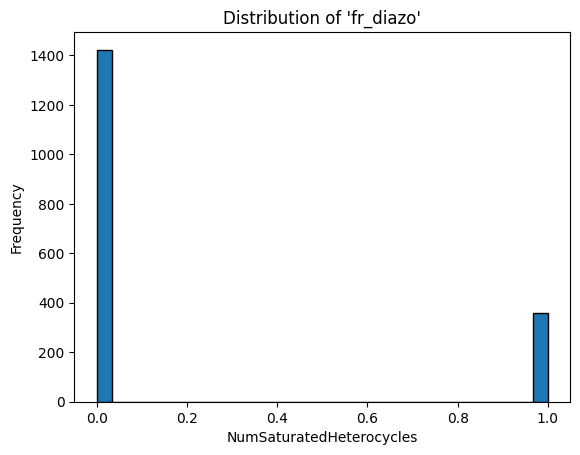

In [137]:
# Plot the histogram
plt.hist(df['Irritation'], bins=30, edgecolor='black')
plt.title("Distribution of 'fr_diazo'")
plt.xlabel("NumSaturatedHeterocycles")
plt.ylabel("Frequency")
plt.show()

In [78]:
# Calculate percentage of each unique value
value_percentages = df['fr_diazo'].value_counts(normalize=True) * 100

# Display as a DataFrame
percentage_df = value_percentages.reset_index()
percentage_df.columns = ['Value', 'Percentage']

print(percentage_df)

   Value  Percentage
0    0.0    99.94382
1    1.0     0.05618


In [79]:
# Calculate Pearson correlation
correlation = df['fr_diazo'].corr(df['Irritation'], method='pearson')
print(f"Pearson Correlation: {correlation}")

# Calculate Spearman correlation (for non-linear relationships)
spearman_corr = df['fr_diazo'].corr(df['Irritation'], method='spearman')
print(f"Spearman Correlation: {spearman_corr}")


Pearson Correlation: -0.011875275230936212
Spearman Correlation: -0.011875275230936231


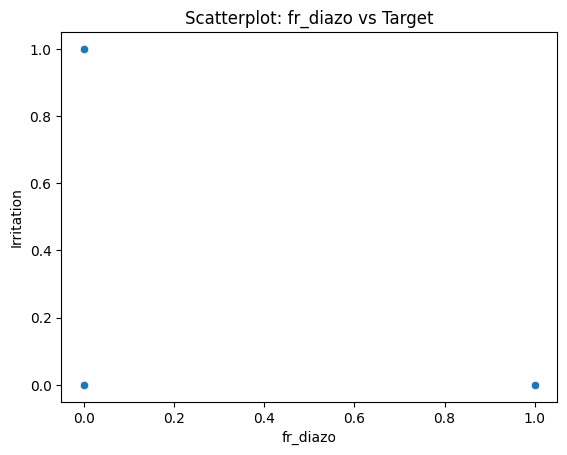

In [80]:
sns.scatterplot(x=df['fr_diazo'], y=df['Irritation'])
plt.title("Scatterplot: fr_diazo vs Target")
plt.show()

## Outliers

In [50]:
def detect_outliers(df):
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df)
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outlier_mask = (df < lower_bound) | (df > upper_bound)
    
    # Replace outliers with median
    median_values = df.median(axis=1)
    df = df.where(~outlier_mask, median_values, axis=0)


    outliers = df[outlier_mask.any(axis=1)]
    num_outliers = outliers.shape[0]
    print(f"Number of outliers detected: {num_outliers}")

    return df

In [24]:
df.size

80444

In [51]:
df = detect_outliers(df)

Number of outliers detected: 439


## Scaling

In [174]:
df_copy = df

In [178]:
df = df_copy

In [172]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the DataFrame
normalized_data = scaler.fit_transform(df)

# Convert the scaled data back to a DataFrame
df = pd.DataFrame(normalized_data, columns=df.columns)

df.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,0.380977,0.381131,0.301948,0.296826,0.403803,0.385193,0.187251,0.169542,0.187203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277350,0.0
1,1.0,0.443959,0.444111,0.118847,0.252329,0.725612,0.470253,0.326442,0.308640,0.326380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,1.0,0.049599,0.049660,0.376730,0.332135,0.440935,0.382546,0.249141,0.240783,0.247628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160128,0.0
3,1.0,0.297132,0.297283,0.200094,0.265977,0.634828,0.454915,0.257268,0.234392,0.257216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,1.0,0.067411,0.067485,0.305414,0.298200,0.501957,0.647698,0.225299,0.206815,0.225230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


## Class distribution

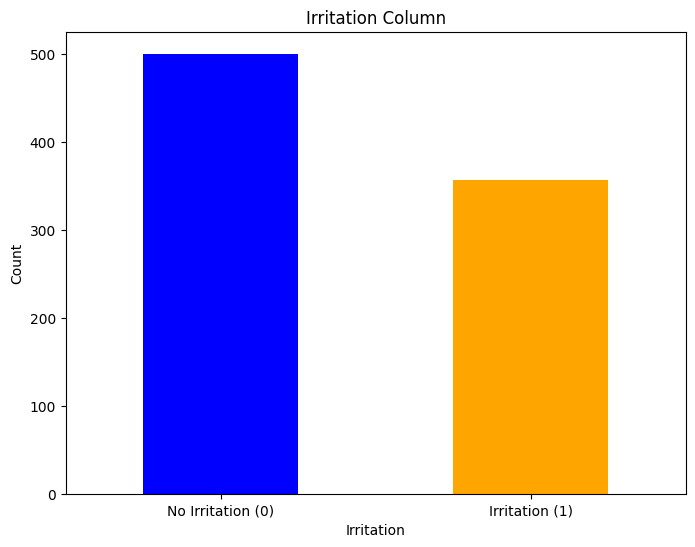

In [191]:
# Plotting class imbalance
plt.figure(figsize=(8, 6))
df_final['Irritation'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Irritation Column')
plt.xlabel('Irritation')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Irritation (0)', 'Irritation (1)'], rotation=0)
plt.show()

In [189]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.spatial.distance import cdist

# Predpokladáme: X = pandas DataFrame (features), y = pandas Series (target)
# 0 = väčšinová trieda, 1 = minoritná trieda (zmeň ak máš opačne)
X = df.drop(columns="Irritation")
y = df["Irritation"]

majority_class = 0

# 1. Vyber väčšinovú triedu a resetuj indexy
X_majority = X[y == majority_class].reset_index(drop=True)

# 2. Škálovanie dát
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_majority)

# 3. KMeans clustering (napr. 50 klastrov)
n_clusters = 500  # môžeš zmeniť podľa veľkosti datasetu
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# 4. Vyber 1 najbližšiu vzorku ku každému centroidu
centroids = kmeans.cluster_centers_
distances = cdist(X_scaled, centroids)
closest_indices = np.argmin(distances, axis=0)

# 5. Zostav nový dataset (vybrané vzorky z väčšinovej triedy)
X_majority_selected = X_majority.iloc[closest_indices]
y_majority_selected = pd.Series([majority_class] * len(closest_indices), index=X_majority_selected.index)

# 6. Pridaj všetky vzorky minoritnej triedy
X_minority = X[y != majority_class]
y_minority = y[y != majority_class]

# 7. Spoj dokopy
X_final = pd.concat([X_majority_selected, X_minority], axis=0)
y_final = pd.concat([y_majority_selected, y_minority], axis=0)

# 8. Zamiešaj výsledný dataset
X_final, y_final = shuffle(X_final, y_final, random_state=42)


In [188]:
df_final = X_final.copy()
df_final["Irritation"] = y_final.values


In [190]:
df_final.shape

(857, 203)

# Data download

In [192]:
import os

# Define the file name (you can customize it)
file_name = "rabbit_balanced.xlsx"

# Export the DataFrame to Excel
df_final.to_excel(file_name, index=False)  # index=False excludes the index column

# Optionally, you can confirm the file was saved in the current directory
print(f"File saved to: {os.path.abspath(file_name)}")


File saved to: /Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation/rabbit_balanced.xlsx


In [62]:
rabits

,Name,Synonym,CAS RN,Y,Detailed Page,Evidence,OECD TG 404,Data Source,Frequency,SMILES,SMILES URL,SMILES Source,Canonical SMILES,Split
0,JP_CHRIP:\np-Nitrochlorobenzene,JP_CHRIP:\np-Chloronitrobenzene\n1-Chloro-4-ni...,100-00-5,0,JP_CHRIP: https://www.nite.go.jp/chem/ghs/21-m...,JP_CHRIP:\n【分類根拠】\n（１）、（２）より、区分に該当しない（国連分類基準の区...,Provided,JP_CHRIP,1,O=[N+]([O-])c1ccc(Cl)cc1,https://jglobal.jst.go.jp/en/redirect?Nikkaji_...,J-GLOBAL,O=[N+]([O-])c1ccc(Cl)cc1,Train
3,EU_REACH:\nbutyl N-[(butylsulfanyl)methanethio...,None,1001320-38-2,0,EU_REACH: https://echa.europa.eu/registration-...,"EU_REACH:\nExperimental study (OECD TG 404, GLP)",Provided,EU_REACH,1,CCCCOC(=O)NC(=S)SCCCC,https://pubchem.ncbi.nlm.nih.gov/compound/8766...,PubChem,CCCCOC(=O)NC(=S)SCCCC,Train
4,"EU_REACH:\n(1S,3R,5R,6S,8R,10R,11S,13R,15R,16S...",None,10016-20-3,0,EU_REACH: https://echa.europa.eu/registration-...,"EU_REACH:\nExperimental study (OECD TG 404, GLP)",Provided,EU_REACH,1,OC[C@H]1O[C@@H]2O[C@H]3[C@H](O)[C@@H](O)[C@@H]...,https://pubchem.ncbi.nlm.nih.gov/compound/444913,PubChem,OC[C@H]1O[C@@H]2O[C@H]3[C@H](O)[C@@H](O)[C@@H]...,Train
7,EU_REACH:\n1-butoxy-4-[4-(trans-4-ethylcyclohe...,None,1003218-33-4,0,EU_REACH: https://echa.europa.eu/registration-...,"EU_REACH:\nExperimental study (OECD TG 404, GLP)",Provided,EU_REACH,1,CCCCOc1ccc(C2=CCC(C3CCC(CC)CC3)CC2)c(F)c1F,https://pubchem.ncbi.nlm.nih.gov/compound/1472...,PubChem,CCCCOc1ccc(C2=CCC(C3CCC(CC)CC3)CC2)c(F)c1F,Train
8,"EU_REACH:\n4-methyl-1,3-oxazole-5-carbonitrile",None,1003-52-7,0,EU_REACH: https://echa.europa.eu/registration-...,"EU_REACH:\nExperimental study (OECD TG 404, GLP)",Provided,EU_REACH,1,Cc1ncoc1C#N,https://pubchem.ncbi.nlm.nih.gov/compound/70480,PubChem,Cc1ncoc1C#N,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,EU_REACH:\n2-(2-{2-[(2-ethylhexanoyl)oxy]ethox...,None,94-28-0,0,EU_REACH: https://echa.europa.eu/registration-...,"EU_REACH:\nExperimental study (OECD TG 404, GLP)",Provided,EU_REACH,1,CCCCC(CC)C(=O)OCCOCCOCCOC(=O)C(CC)CCCC,https://pubchem.ncbi.nlm.nih.gov/compound/7185,PubChem,CCCCC(CC)C(=O)OCCOCCOCCOC(=O)C(CC)CCCC,Test
2480,EU_REACH:\n(4-chloro-2-fluoro-3-methoxyphenyl)...,None,944129-07-1,0,EU_REACH: https://echa.europa.eu/registration-...,"EU_REACH:\nExperimental study (OECD TG 404, GLP)",Provided,EU_REACH,1,COc1c(Cl)ccc(B(O)O)c1F,https://pubchem.ncbi.nlm.nih.gov/compound/4412...,PubChem,COc1c(Cl)ccc(B(O)O)c1F,Test
2483,EU_REACH:\n4-[4-(prop-2-en-1-yloxy)benzenesulf...,None,97042-18-7,0,EU_REACH: https://echa.europa.eu/registration-...,"EU_REACH:\nExperimental study (OECD TG 404, GLP)",Provided,EU_REACH,1,C=CCOc1ccc(S(=O)(=O)c2ccc(O)cc2)cc1,https://pubchem.ncbi.nlm.nih.gov/compound/2054598,PubChem,C=CCOc1ccc(S(=O)(=O)c2ccc(O)cc2)cc1,Test
2484,EU_REACH:\n4-methoxy-3-nitro-N-phenylbenzamide,None,97-32-5,0,EU_REACH: https://echa.europa.eu/registration-...,"EU_REACH:\nExperimental study (OECD TG 404, GLP)",Provided,EU_REACH,1,COc1ccc(C(=O)Nc2ccccc2)cc1[N+](=O)[O-],https://pubchem.ncbi.nlm.nih.gov/compound/7331,PubChem,COc1ccc(C(=O)Nc2ccccc2)cc1[N+](=O)[O-],Test


In [65]:
rabbit_names = rabits[["Name", "CAS RN", "SMILES"]]

In [66]:
rabbit_names

,Name,CAS RN,SMILES
0,JP_CHRIP:\np-Nitrochlorobenzene,100-00-5,O=[N+]([O-])c1ccc(Cl)cc1
3,EU_REACH:\nbutyl N-[(butylsulfanyl)methanethio...,1001320-38-2,CCCCOC(=O)NC(=S)SCCCC
4,"EU_REACH:\n(1S,3R,5R,6S,8R,10R,11S,13R,15R,16S...",10016-20-3,OC[C@H]1O[C@@H]2O[C@H]3[C@H](O)[C@@H](O)[C@@H]...
7,EU_REACH:\n1-butoxy-4-[4-(trans-4-ethylcyclohe...,1003218-33-4,CCCCOc1ccc(C2=CCC(C3CCC(CC)CC3)CC2)c(F)c1F
8,"EU_REACH:\n4-methyl-1,3-oxazole-5-carbonitrile",1003-52-7,Cc1ncoc1C#N
...,...,...,...
2477,EU_REACH:\n2-(2-{2-[(2-ethylhexanoyl)oxy]ethox...,94-28-0,CCCCC(CC)C(=O)OCCOCCOCCOC(=O)C(CC)CCCC
2480,EU_REACH:\n(4-chloro-2-fluoro-3-methoxyphenyl)...,944129-07-1,COc1c(Cl)ccc(B(O)O)c1F
2483,EU_REACH:\n4-[4-(prop-2-en-1-yloxy)benzenesulf...,97042-18-7,C=CCOc1ccc(S(=O)(=O)c2ccc(O)cc2)cc1
2484,EU_REACH:\n4-methoxy-3-nitro-N-phenylbenzamide,97-32-5,COc1ccc(C(=O)Nc2ccccc2)cc1[N+](=O)[O-]


In [68]:
import os

# Define the file name (you can customize it)
file_name = "rabbit_names.xlsx"

# Export the DataFrame to Excel
rabbit_names.to_excel(file_name, index=False)  # index=False excludes the index column

# Optionally, you can confirm the file was saved in the current directory
print(f"File saved to: {os.path.abspath(file_name)}")


File saved to: /Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation/rabbit_names.xlsx
